##Importing Necessary Libraries and Loading the dataset

In [1]:
!pip install -U accelerate
!pip install -U transformers

In [2]:
#The converted json --> Excel file is saved in the drive and mounted
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Reading the file contents and creating a dataframe
import pandas as pd

df = pd.read_excel('/content/drive/My Drive/output_excel_file.xlsx')

df.columns

Index(['post_title', 'post_text', 'annotations.1', 'annotations.2',
       'annotations.3', 'annotations.4', 'annotations.5', 'annotations.6',
       'annotations.7', 'annotations.8', 'annotations.9'],
      dtype='object')

In [4]:
# Converting the labels to resonable format
columns_to_convert = ['annotations.1', 'annotations.2', 'annotations.3', 'annotations.4', 'annotations.5', 'annotations.6', 'annotations.7', 'annotations.8', 'annotations.9']

# Iterate through each column and convert 'yes' to 1 and 'no' to 0
for col in columns_to_convert:
    df[col] = df[col].replace({'yes': 1, 'no': 0, ' yes':1,' no':0})

print(df[columns_to_convert].dtypes)

annotations.1    int64
annotations.2    int64
annotations.3    int64
annotations.4    int64
annotations.5    int64
annotations.6    int64
annotations.7    int64
annotations.8    int64
annotations.9    int64
dtype: object


In [5]:
df.head()

,post_title,post_text,annotations.1,annotations.2,annotations.3,annotations.4,annotations.5,annotations.6,annotations.7,annotations.8,annotations.9
0,I don't feel original anymore.,"When I was in high school a few years back, I ...",1,0,1,1,0,0,0,0,0
1,I don’t have anyone to talk to and I don’t kno...,Nine years ago I was diagnosed with depression...,1,1,0,0,1,0,0,0,0
2,Stuck between moving forward and killing myself,Some background information: My GF of almost 3...,1,1,1,1,0,0,1,0,0
3,I need help on how to help my girlfriend.,"My girlfriend ,of about 3 months now ,has been...",1,1,0,0,0,0,1,0,0
4,I've been feeling this way for some tine,I'm alway feeling like this. It doesn't even m...,1,1,0,0,0,0,0,0,0


## Exploratory Data Analysis

In [6]:
df.shape
df.info()

df.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1996 entries, 0 to 1995
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   post_title     1996 non-null   object
 1   post_text      1996 non-null   object
 2   annotations.1  1996 non-null   int64 
 3   annotations.2  1996 non-null   int64 
 4   annotations.3  1996 non-null   int64 
 5   annotations.4  1996 non-null   int64 
 6   annotations.5  1996 non-null   int64 
 7   annotations.6  1996 non-null   int64 
 8   annotations.7  1996 non-null   int64 
 9   annotations.8  1996 non-null   int64 
 10  annotations.9  1996 non-null   int64 
dtypes: int64(9), object(2)
memory usage: 171.7+ KB


0

<ipython-input-7-aa03b2a2a69f>:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(label_names, rotation=45, ha='right')


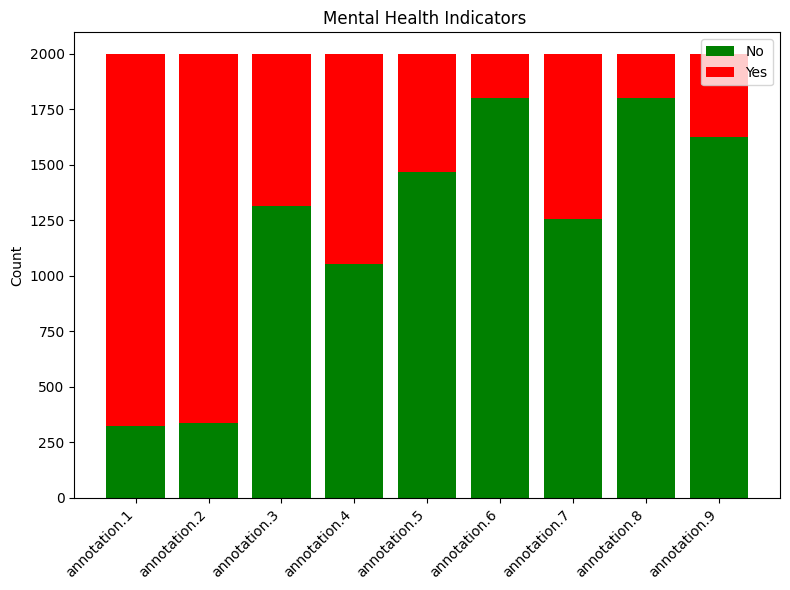

In [7]:
# Code to visualize different mental health annotators and their corresponding yes - no counts
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have multi-label annotations for the entire dataset
full_labels = df[columns_to_convert]

# Count the occurrences of zeros and ones for each label
zeros_counts = np.sum(full_labels == 0, axis=0)
ones_counts = np.sum(full_labels == 1, axis=0)

# Labels for each binary label
label_names = ['annotation.1', 'annotation.2', 'annotation.3', 'annotation.4', 'annotation.5', 'annotation.6', 'annotation.7', 'annotation.8', 'annotation.9']

# Plotting
fig, ax = plt.subplots(figsize=(8, 6))

# Entire dataset bar plot
ax.bar(label_names, zeros_counts, color='green', label='No')
ax.bar(label_names, ones_counts, bottom=zeros_counts, color='red', label='Yes')

ax.set_title('Mental Health Indicators ')
ax.set_ylabel('Count')
ax.legend()

# Rotate x-axis labels for better readability
ax.set_xticklabels(label_names, rotation=45, ha='right')

plt.tight_layout()
plt.show()



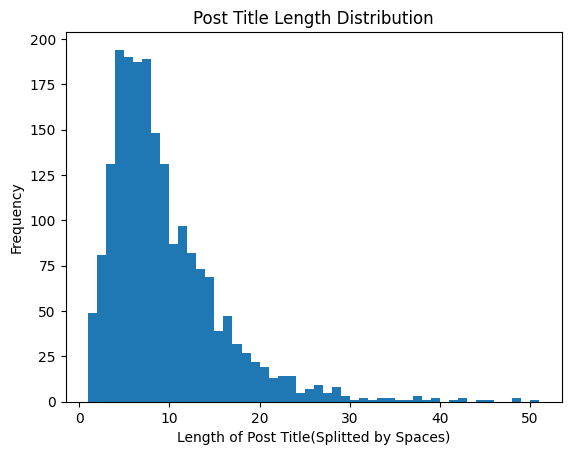

In [8]:
import matplotlib.pyplot as plt

word_count_title = df['post_title'].apply(lambda x: len(str(x).split()))

# Plot the histogram for word count
word_count_title.plot.hist(bins=50)
plt.title('Post Title Length Distribution')
plt.xlabel('Length of Post Title(Splitted by Spaces)')
plt.ylabel('Frequency')
plt.show()

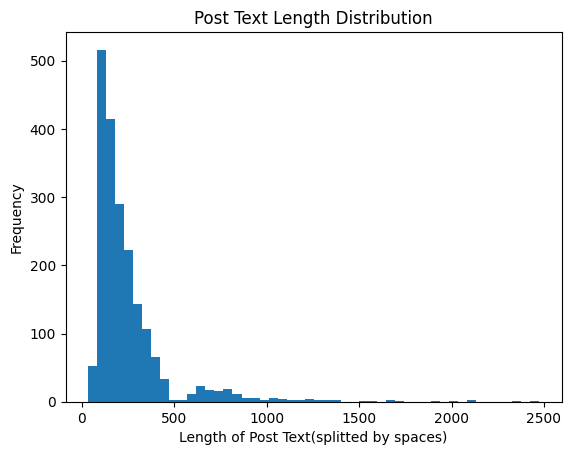

In [9]:
word_count_text = df['post_text'].apply(lambda x: len(str(x).split()))

# Plot the histogram for word count
word_count_text.plot.hist(bins=50)
plt.title('Post Text Length Distribution')
plt.xlabel('Length of Post Text(splitted by spaces)')
plt.ylabel('Frequency')
plt.show()

## Data Pre-processing and Text-Cleaning

In [10]:
! pip install emoji

In [11]:
import torch
from transformers import DistilBertTokenizer, AutoTokenizer
from transformers import DistilBertForSequenceClassification, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset

In [12]:
from sklearn.model_selection import train_test_split

# Splitting the dataset into train, validation, and test sets
test_split = 0.2  # 20% of the original dataset for test
val_split = 0.1   # 10% of the original dataset for validation

# Splitting the original dataset into train and test sets
train_df, test_df = train_test_split(df, test_size=test_split, random_state=42)

# Further splitting the test set into validation and test sets
train_df, val_df = train_test_split(train_df, test_size=val_split/(1-test_split), random_state=42)

# Display the number of rows in each set
print(f"Number of rows in training set: {len(train_df)}")
print(f"Number of rows in validation set: {len(val_df)}")
print(f"Number of rows in test set: {len(test_df)}")


Number of rows in training set: 1396
Number of rows in validation set: 200
Number of rows in test set: 400


In [13]:
train_df.head()

,post_title,post_text,annotations.1,annotations.2,annotations.3,annotations.4,annotations.5,annotations.6,annotations.7,annotations.8,annotations.9
492,How do I become a person?,Ok That might be a weird question but I needed...,1,1,1,1,0,0,0,0,0
1487,I don’t want to go swimming at the lake tonigh...,But it seems like I’ve been crying out for hel...,1,0,0,0,0,0,1,0,0
1860,Does anyone else feel like the world is incred...,I’ve never been treated nicely by anyone. Even...,1,0,0,0,0,0,1,0,0
243,Is anyone in the same position as me?,Hey this might be long but oh welll we all lov...,1,1,0,1,0,0,1,0,0
1713,Depression killing right now. I could use some...,"Hi, I'm Mark, I'm 22 and I live near Berlin, G...",1,1,0,0,0,0,1,0,0


In [14]:
not_chosen_columns = ['post_text', 'post_title']

# Select label columns that are not in the list of not chosen columns
label_columns = [col for col in df.columns if col not in not_chosen_columns]

# Create a new DataFrame containing only the selected label columns
labels_train = train_df[label_columns]
labels_val=val_df[label_columns]
labels_test = test_df[label_columns]


# Convert the label columns to lists for each row
labels_list_train = labels_train.values
labels_list_val = labels_val.values
labels_list_test = labels_test.values

In [15]:
print((labels_list_train))

[[1 1 1 ... 0 0 0]
 [1 0 0 ... 1 0 0]
 [1 0 0 ... 1 0 0]
 ...
 [1 1 0 ... 0 0 1]
 [1 1 0 ... 0 0 0]
 [1 1 0 ... 1 0 0]]


In [16]:
combined_train = train_df['post_title'] + ' ' + train_df['post_text']
combined_val = val_df['post_title'] + ' ' + val_df['post_text']
combined_test=test_df['post_title'] + ' ' + test_df['post_text']
print(type(combined_train))

<class 'pandas.core.series.Series'>


In [17]:

train_text = combined_train.astype(str)
train_labels = labels_list_train
test_text=combined_test.astype(str)
val_text = combined_val.astype(str)
val_labels = labels_list_val
test_text = combined_test.astype(str)
test_labels = labels_list_test

In [18]:
import re
import emoji
import string
from torch.utils.data import Dataset
import torch
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import nltk
nltk.download('stopwords')
nltk.download('punkt')

def clean_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Handle emojis
    text = emoji.demojize(text)
    text = re.sub(r':', ' ', text)

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    text = ' '.join([word for word in word_tokens if word.lower() not in stop_words])

    # Remove extra whitespaces
    text = re.sub(' +', ' ', text).strip()

    return text


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [39]:
# Cleaned Text for further Processing
train_text_cleaned =train_text.apply(clean_text)

val_text_cleaned = val_text.apply(clean_text)

##Tokenization and Model Building


In [20]:
# Loading the DistillBert Model for training
checkpoint = "distilbert-base-uncased"
tokenizer = DistilBertTokenizer.from_pretrained(checkpoint)
model = DistilBertForSequenceClassification.from_pretrained(checkpoint, num_labels=9,
                                                            problem_type="multi_label_classification")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
#Creating encodings to further feed into the model
train_text_encodings = tokenizer(train_text_cleaned.tolist(), padding="max_length", truncation=True, max_length=512)
val_text_encodings = tokenizer(val_text_cleaned.tolist(), padding="max_length", truncation=True, max_length=512)


##Custom Dataset Creation

In [22]:
max_length = 512

class TextClassifierDataset(Dataset):
    def __init__(self, encodings, labels, max_length=512):
        self.encodings = encodings
        self.labels = labels
        self.max_length = max_length

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        input_ids = torch.tensor(self.encodings['input_ids'][idx])
        attention_mask = torch.tensor(self.encodings['attention_mask'][idx])

        # Truncate or pad to the specified max_length
        input_ids = input_ids[:self.max_length]
        attention_mask = attention_mask[:self.max_length]

        item = {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': torch.tensor(self.labels[idx], dtype=torch.float32)
        }
        return item




In [23]:

train_dataset = TextClassifierDataset(train_text_encodings, train_labels, max_length)
val_dataset = TextClassifierDataset(val_text_encodings, val_labels, max_length)

In [24]:
type(train_dataset[1])

dict

In [25]:
# Visualizing the formed Dataset
print(train_dataset[1])

{'input_ids': tensor([  101,  1521,  2215,  2175,  5742,  2697,  3892,  3849,  2066,  1521,
         6933,  2393,  2296,  2391,  1521,  2699,  2191,  2028,  4699,  5094,
         2126,  1521,  2356, 14181, 13512, 29278, 18150,  8244,  6107, 16169,
         2565, 14181, 13512, 29278, 18150,  2495,  6633, 24759,  6977,  3672,
        13117,  2015, 14181, 13512, 29278, 18150,  4735,  6026,  2137,  2576,
         9147,  2359,  2468,  8239,  2658,  3850,  3220,  2359,  2393,  2500,
         2437,  4507,  2322,  2086,  2551,  2875,  2894,  1521,  2505,  2191,
         4507,  3849,  2066,  6343, 14977,  8563,  3043,  2524,  1521,  2699,
         6162,  3125,  1521,  2467,  2272,  2460,  7955,  2842,  3084,  2112,
         7367, 17603, 16961,  4279,  3892,  1521, 25247,  4954,  5886, 11276,
         9880,  2690,  2697,  2203,  6343,  4122,  2393,  1521,  2356,  2393,
         6343,  4122, 10408,  4522,  7300,  1521,  2699,  2556,  2111,  6343,
         4122,  2130,  3543,  2292,  2894,  2729, 

##Evaluation Metrics and Training

In [26]:
# Multi-Label Classification Evaluation Metrics
import numpy as np
from sklearn.metrics import roc_auc_score, f1_score, hamming_loss, accuracy_score, precision_score, recall_score
from transformers import EvalPrediction
import torch

def multi_labels_metrics(predictions, labels, threshold=0.3):
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))

    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    y_true = labels

    f1 = f1_score(y_true, y_pred, average='macro')
    roc_auc = roc_auc_score(y_true, y_pred, average='macro')
    hamming = hamming_loss(y_true, y_pred)

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')

    metrics = {
        "roc_auc": roc_auc,
        "hamming_loss": hamming,
        "f1": f1,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall
    }

    return metrics

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions

    result = multi_labels_metrics(predictions=preds,
                                  labels=p.label_ids)

    return result


In [27]:
# Training Arguments
from transformers import TrainingArguments, Trainer

args = TrainingArguments(
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    output_dir = './results',
    num_train_epochs=5,
    save_steps=200,
    save_total_limit=2)



trainer = Trainer(model=model,
                  args=args,
                  train_dataset=train_dataset,
                  eval_dataset = val_dataset,
                  compute_metrics=compute_metrics)





In [28]:
trainer.train()

Step,Training Loss
500,0.465300


TrainOutput(global_step=875, training_loss=0.4119858660016741, metrics={'train_runtime': 344.834, 'train_samples_per_second': 20.242, 'train_steps_per_second': 2.537, 'total_flos': 924737867919360.0, 'train_loss': 0.4119858660016741, 'epoch': 5.0})

In [31]:
trainer.evaluate()

{'eval_loss': 0.4043905735015869,
 'eval_roc_auc': 0.6755502515513427,
 'eval_hamming_loss': 0.2011111111111111,
 'eval_f1': 0.6719424381476652,
 'eval_accuracy': 0.125,
 'eval_precision': 0.7078052122080063,
 'eval_recall': 0.7569968675657848,
 'eval_runtime': 3.2391,
 'eval_samples_per_second': 61.746,
 'eval_steps_per_second': 7.718,
 'epoch': 5.0}

## Model Saving

In [32]:
trainer.save_model("final_model")

# Evaluate on training dataset


In [46]:

trainer.save_model('/content/drive/MyDrive/final_model.h5')


## Results on Training , Validation and Test Datasets

In [37]:
train_results = trainer.evaluate(train_dataset)
print("Training Results:", train_results)

# Evaluate on testing dataset
val_results = trainer.evaluate(val_dataset)
print("Testing Results:", val_results)


Training Results: {'eval_loss': 0.3003917932510376, 'eval_roc_auc': 0.7306568408947467, 'eval_hamming_loss': 0.14812161731932505, 'eval_f1': 0.7402545892002979, 'eval_accuracy': 0.2148997134670487, 'eval_precision': 0.7174723878610284, 'eval_recall': 0.8153550455631311, 'eval_runtime': 23.3295, 'eval_samples_per_second': 59.839, 'eval_steps_per_second': 7.501, 'epoch': 5.0}
Testing Results: {'eval_loss': 0.4043905735015869, 'eval_roc_auc': 0.6755502515513427, 'eval_hamming_loss': 0.2011111111111111, 'eval_f1': 0.6719424381476652, 'eval_accuracy': 0.125, 'eval_precision': 0.7078052122080063, 'eval_recall': 0.7569968675657848, 'eval_runtime': 3.6786, 'eval_samples_per_second': 54.369, 'eval_steps_per_second': 6.796, 'epoch': 5.0}


In [41]:
test_text_cleaned = test_text.apply(clean_text)

test_text_encodings = tokenizer(test_text_cleaned.tolist(), padding="max_length", truncation=True, max_length=512)

test_dataset = TextClassifierDataset(test_text_encodings, test_labels, max_length)

In [44]:
print(test_text_cleaned.iloc[5])


study ms aborad leave parents shy introvert person infj personalityl social anxietyi dont passion goal lifei want earn money leave stressful life people call selfish leave country ones break relationships money reality life really money many people hate saying true anyone sweet talking say money isnt everything hypocrisy want leave india one take care parents gone clinical depression lifeit happened 1015yrsmy father 60yrs old still using antidepressants sleeping pills dailyyeah time doesnt fix everyone want leave place settle foreign start new life always gone depression loneliness moving abroad worsen everything


In [45]:
test_results = trainer.evaluate(test_dataset)
print("Testing Results:", test_results)

Testing Results: {'eval_loss': 0.3878082036972046, 'eval_roc_auc': 0.6757301789140817, 'eval_hamming_loss': 0.19194444444444445, 'eval_f1': 0.6609168300202576, 'eval_accuracy': 0.1325, 'eval_precision': 0.6043347547449441, 'eval_recall': 0.7417204981615515, 'eval_runtime': 6.3378, 'eval_samples_per_second': 63.113, 'eval_steps_per_second': 7.889, 'epoch': 5.0}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Final Results for Submission
'eval_loss': 0.3878082036972046

'eval_roc_auc': 0.6757301789140817

'eval_hamming_loss': 0.19194444444444445

'eval_f1': 0.6609168300202576

'eval_accuracy': 0.1325

'eval_precision': 0.6043347547449441

'eval_recall': 0.7417204981615515

'eval_runtime': 6.3378


## Visualizing Predictions

In [47]:
text = test_text_cleaned.iloc[5]
encoding = tokenizer(text, return_tensors='pt')
encoding.to(trainer.model.device)

outputs = trainer.model(**encoding)

In [52]:
sigmoid = torch.nn.Sigmoid()
probs = sigmoid(outputs.logits[0].cpu())
preds = np.zeros(probs.shape)
preds[np.where(probs>=0.3)] = 1

preds.reshape(1,-1) # Predicted Labels

array([[1., 1., 1., 1., 1., 0., 0., 0., 1.]])

In [53]:
print(test_labels[5]) ## Actual Labels

[1 1 0 0 1 0 0 0 1]
